# Gibbs Sampling for Topic Link Block LDA
## Derek Owens-Oas
## Duke University Statistical Science
## STA 663 Final Project

##### Import packages and functions:

In [1]:
# Import packages:
import pandas as pd
import io
import requests
import numpy as np
import scipy as sp
from scipy.misc import logsumexp
import time
import numpy.random as npr
import matplotlib.pyplot as plt
from numba import jit, vectorize, float64, int64
import itertools
import multiprocessing as mp
import pickle
from functools import partial
%matplotlib inline
%load_ext Cython

##### Read in data from dropbox URL, filter out posts not falling in the specified (zero-indexed) days of the year, display a few rows, and organize the data into dates, domains, list of link lists, and list of word lists:

In [2]:
# Read blog posts csv in from web url as pandas data frame:
url="https://www.dropbox.com/s/20egdva07p7p4wf/textNetwork.csv?dl=1"
s=requests.get(url).content
blog_posts = pd.read_csv(io.StringIO(s.decode('latin-1')))
blog_posts = blog_posts.drop('Unnamed: 0', 1)
blog_posts = blog_posts.loc[blog_posts['dates'].isin(sorted(set(blog_posts['dates']))[0:7])]

In [3]:
# Print 5 rows of the data frame:
blog_posts.head(5)

,dates,domains,links,words
0,01/01/2012,aconservativeteacher.blogspot.com,blogs.the-american-interest.com directorblue.b...,public school teacher day battle believe life ...
1,01/01/2012,althouse.blogspot.com,balkin.blogspot.com legalinsurrection.com reas...,boy green bay today greatest really game maybe...
2,01/01/2012,althouse.blogspot.com,balkin.blogspot.com legalinsurrection.com reas...,girl girl good said shows bad way says say sai...
3,01/01/2012,althouse.blogspot.com,balkin.blogspot.com legalinsurrection.com reas...,impossible defeat sitting potus said ron paul ...
4,01/01/2012,althouse.blogspot.com,balkin.blogspot.com legalinsurrection.com reas...,intended purpose form hostile practical joke c...


##### Define functions to sample $b_n$|-, $z_{wn}$|-, $\phi_k$|-, $\pi_b$|-, and $\theta_b$|- from their full posterior conditional distributions and a function to find counts $c_{vk}$, $c_{bl}$, and $c_{bk}$. 

In [4]:
# Create function to initialize N observations into B blocks, assuring that each block occurs homogenously:
def init_block_assigns(num_obs, num_blocks):
    block_partition = np.array_split(np.arange(num_obs), num_obs//(num_obs//num_blocks))
    return np.concatenate([np.repeat(b,len(block_partition[b])) for b in range(num_blocks)]).ravel()

In [5]:
# Create b_given_y_z_pi_theta function:
def b_given_y_z_pi_theta(y, z, pi, theta, num_obs, num_blocks):
    b_n = np.zeros(num_obs, dtype=np.int64)
    for n_ind in range(num_obs):
        log_q_bn = -np.log(num_blocks) + np.log(pi[:, list(y[n_ind])]).sum(axis=1) + np.log(theta[:, z[n_ind]]).sum(axis=1)
        exp_log_p_bn = np.exp(log_q_bn - logsumexp(log_q_bn))
        exp_log_p_bn /= exp_log_p_bn.sum().astype(float)
        b_n[n_ind] = np.random.multinomial(1,exp_log_p_bn).argmax()
    return b_n

In [6]:
# Create b_given_y_z_pi_theta_fast function:
def b_given_y_z_pi_theta_fast(b, y, z, pi, theta, num_obs, num_blocks):
    for n_ind in range(num_obs):
        #start_log_calc = time.time()
        log_q_bn = -np.log(num_blocks) + np.log(pi[:, list(y[n_ind])]).sum(axis=1) + np.log(theta[:, z[n_ind]]).sum(axis=1)
        #print("log calc time")
        #print(time.time()-start_log_calc)
        #start_exp_logsumexp = time.time()
        exp_log_p_bn = np.exp(log_q_bn - logsumexp(log_q_bn))
        #print("exp logsumexp time")
        #print(time.time()-start_exp_logsumexp)
        #start_renorm = time.time()
        exp_log_p_bn /= exp_log_p_bn.sum().astype(float)
        #print("renorm time")
        #print(time.time()-start_renorm)
        #start_samp_b_mult = time.time()
        b[n_ind] = np.random.multinomial(1,exp_log_p_bn).argmax()
        #print("samp b mult time")
        #print(time.time()-start_samp_b_mult)  
    return b

In [7]:
# Define functions to parallelize multinomial sampling across cores:

# Draws multiple samples from a multinomial with different probability vector for each sample: 
def sample_mult_prob_matrix(prob_wk_subset):
    word_topic_assign = np.zeros(prob_wk_subset.shape[0], dtype=np.int64)
    for w in range(prob_wk_subset.shape[0]):
        word_topic_assign[w] = np.random.multinomial(1, prob_wk_subset[w,:]).argmax()
    return word_topic_assign
   
# Create function to sample a single categorical assignment:
def sample_single_mult_prob(prob_k):
    return np.random.multinomial(1, prob_k).argmax()    
    
# Takes matrix of probabilities and partitions it across cores, performing multinomial sampling 
# on each core and recombining the output into a vector of assignments:
def parallelize_multinomial(word_topic_assigns, prob_wk, num_cores):
    #start_pool = time.time()
    #pool = mp.Pool(num_cores)
    #print("pool time:")
    #print(time.time()-start_pool)
    W = prob_wk.shape[0]
    indices = np.arange(W)
    #start_partition = time.time()
    partition_indices = np.array_split(indices, indices.shape[0]//(indices.shape[0]//num_cores))
    #print("partition time:")
    #print(time.time()-start_partition)
    #result_arrays = pool.map(sample_mult_prob_matrix_cython, (prob_wk[partition_indices[i], :] for i in range(num_cores)))
    #start_map_sample = time.time()
    #result_arrays = pool.map(sample_mult_prob_matrix, (prob_wk[partition_indices[i], :] for i in range(num_cores)))
    #print("map sample time:")
    #print(time.time()-start_map_sample)
    result_arrays = list(map(sample_mult_prob_matrix, (prob_wk[partition_indices[i], :] for i in range(num_cores))))
    #result_arrays = list(map(sample_single_mult_prob, (prob_wk[i, :] for i in range(W)))) # is this faster?
    #print(result_arrays)
    #word_topic_assigns = np.array(result_arrays, dtype=np.int64) # is this faster?
    #start_concat = time.time()
    word_topic_assigns = np.concatenate(result_arrays).ravel()
    #print("concat time:")
    #print(time.time()-start_concat)
    return word_topic_assigns

# Define function to reconstruct documents after vectorizing them for fast sampling:

# Create helper function reconstruct_docs to take vectorized word_topic_assigns
# and return documents as numpy array of integer arrays:
def reconstruct_docs(cum_doc_lengths, z, topic_assignments, num_obs):
        start_word_ind = 0
        for n_ind in range(num_obs):
            if n_ind > 0: 
                start_word_ind = cum_doc_lengths[n_ind-1]
            end_word_ind = cum_doc_lengths[n_ind]  
            z[n_ind] = topic_assignments[start_word_ind:end_word_ind]
        return z

In [8]:
# Create z_given_b_x_phi_theta function:
def z_given_b_x_phi_theta(b, x, z, phi, theta, num_obs, num_topics, num_blocks):
    for n_ind in range(num_obs):
        log_q_wkn = np.log(phi[x[n_ind],:]) + np.log(theta[b[n_ind], :])[None,:]
        for w_ind in range(len(x[n_ind])):
            exp_log_p_wkn = np.exp(log_q_wkn[w_ind,:] - logsumexp(log_q_wkn[w_ind,:]))
            z[n_ind][w_ind] = np.random.multinomial(1,exp_log_p_wkn).argmax()
    return z 

In [9]:
# Create z_given_b_x_phi_theta vectorized function:
def z_given_b_x_phi_theta_vec(all_words, word_topic_assigns, word_doc_assign, cum_doc_lengths, b_n, z_wn, phi_vk, theta_bk, num_obs, num_topics, num_blocks, num_cores):
    
    # Compute topic probabilities for each word:
    #start_calc_probs = time.time()
    prob_wk = np.multiply(phi_vk[all_words,:],theta_bk[b_n[word_doc_assign],:])
    prob_wk = prob_wk/prob_wk.sum(axis=1)[:,None]
    #print("calc probs time:")
    #print(time.time()-start_calc_probs)
    
    # This is a vectorized cythonized version:
    #word_topic_assigns = sample_mult_prob_matrix_cython(prob_wk, word_topic_assigns)
    #word_topic_assigns = sample_mult_prob_matrix_gen(prob_wk, word_topic_assigns)
    
    # This is a fast vectorized version:
    #for w in range(len(all_words)):
    #    word_topic_assigns[w] = np.random.multinomial(1,prob_wk[w,:]).argmax()
    
    # this is a (faster?) parallelized, vectorized version:
    word_topic_assigns = parallelize_multinomial(word_topic_assigns, prob_wk, num_cores)
    
    # Reconstruct documents into numpy array of arrays:
    #start_reconstruct = time.time()
    z_wn = reconstruct_docs(cum_doc_lengths, z_wn, word_topic_assigns, num_obs)
    #print("reconstruct time:")
    #print(time.time()-start_reconstruct)
    
    return z_wn

In [10]:
# Create find_counts function to take word topic assignments as array of integer arrays
# and return sufficient statistics (counts c_vk, c_bl, and c_bk) for all three dirichlet updates:
def find_counts(b_n, x_wn, y_ln, z_wn, num_obs, num_topics, num_blocks, num_linked_domains, vocab_size):
    c_vk = np.zeros((vocab_size, num_topics))
    c_bl = np.zeros((num_blocks, num_linked_domains))
    c_bk = np.zeros((num_blocks, num_topics))
    for n in range(num_obs):
        for link_ind in y_ln[n]:
            c_bl[b_n[n], link_ind] += 1
        for word_ind in range(len(x_wn[n])):
            c_vk[x_wn[n][word_ind], z_wn[n][word_ind]] += 1
            c_bk[b_n[n], z_wn[n][word_ind]] += 1
    return c_vk, c_bl, c_bk

In [11]:
# Create function to sample phi from its posterior:
def phi_given_c_x_z(c_vk, x, z, phi_vk, beta, vocab_size, num_topics):
    for k in range(num_topics):
        phi_vk[:,k] = np.random.dirichlet(np.repeat(beta, vocab_size) + c_vk[:,k], size = 1)
    return phi_vk

In [12]:
# Create function to sample pi from its posterior:
def pi_given_b_c_y(b, c_bl, y, pi_bl, gamma, num_blocks, num_linked_domains):
    for b in range(num_blocks):
        pi_bl[b,:] = np.random.dirichlet(np.repeat(gamma, num_linked_domains) + c_bl[b,:], size = 1)
    return pi_bl

In [13]:
# Create function to sample theta from its posterior:
def theta_given_b_c_z(b, c_bk, z, theta_bk, alpha, num_blocks, num_topics):
    for b in range(num_blocks):
        theta_bk[b,:] = np.random.dirichlet(np.repeat(alpha, num_topics) + c_bk[b,:], size = 1)
    return theta_bk

##### Create function to perform Gibbs sampling from the Topic Link Block LDA model. It takes as inputs the list of document word lists, list of document link lists, number of blocks, topics, burns, and samples, and the hyperparameters alpha, beta, and gamma. It provides as outputs the post burn posterior samples of all of the model parameters:

In [14]:
# Create topic link block LDA Gibbs sampling function:
def TLB_LDA_Gibbs(blog_posts, num_blocks, num_topics, alpha, beta, gamma, num_burn, num_samps, num_cores):
    
    # Print initializing and start timing:
    start_init = time.time()
    print("Initializing...")
    
    # Setup data as dates (vector of strings), domains (vector of strings), 
    # links (list of vectors of strings), and words (list of vectors of strings):
    dates = np.array(blog_posts['dates'])
    domains = np.array(blog_posts['domains'])
    docs_links = np.array([np.array(str.split(str(string_of_links), ' ')) for string_of_links in blog_posts['links']])
    docs_words = np.array([np.array(str.split(str(string_of_words), ' ')) for string_of_words in blog_posts['words']])

    # Collect vocabulary of words and set of linked domains:
    vocab = dict(zip(set([word for doc in docs_words for word in doc]),np.arange(len(set([word for doc in docs_words for word in doc])))))
    linked_domains = dict(zip(set([link for doc in docs_links for link in doc if link != 'nan']),np.arange(len(set([link for doc in docs_links for link in doc if link != 'nan'])))))

    # Note number of observations, size of vocabulary, number of linked domains:
    num_obs = len(docs_words)
    vocab_size = len(vocab)
    num_linked_domains = len(linked_domains)

    # Change docs_words and docs_links to numeric X and Y and calculate helper quantities for vectorizing:
    x_wn = np.array(list(map(lambda mykeys: np.array([vocab[x] for x in mykeys]), docs_words)))
    y_ln = np.array(list(map(lambda mykeys: np.array([linked_domains[y] for y in mykeys if y != 'nan']), docs_links)))
    all_words = np.array([word for doc in x_wn for word in doc])
    word_doc_assigns = np.array([word for doc in [np.repeat(i, len(docs_words[i])) for i in range(len(docs_words))] for word in doc])
    word_topic_assigns = np.array([0 for doc in x_wn for word in doc])
    cum_doc_lengths = np.cumsum(list(map(len,x_wn)))
    total_num_words = len([word for doc in x_wn for word in doc])
    total_num_links = len([link for doc in y_ln for link in doc])

    # Initialize arrays of all zeros to store posterior samples:
    b_ns = np.zeros((num_obs, (num_samps - num_burn))) # matrix of block assignments for each observation in each iteration
    z_wn_last = np.array([np.zeros(len(n)) for n in x_wn]) # a list of 1d arrays to indicate the currect topic assignment for each word of each observation
    phi_vks = np.zeros((vocab_size, num_topics, (num_samps - num_burn))) # array for probs for each word in each topic on each iteration
    pi_bls = np.zeros((num_blocks, num_linked_domains, (num_samps - num_burn))) # array for probs for each link in each block on each iteration
    theta_bks = np.zeros((num_blocks, num_topics, (num_samps - num_burn))) # array for probs for each topic in each block on each iteration    

    # Randomly simulate initial values from flat priors and flat (augmented) likelihoods:
    #b_n = np.random.choice(np.arange(num_blocks), size = num_obs, p = np.repeat(1.0/num_blocks, num_blocks))
    b_n = init_block_assigns(num_obs, num_blocks) # Currently blocks are initialized so that each occurs homogenously
    z_wn = np.array(list(map(lambda doc: np.random.choice(np.arange(num_topics), size = len(doc), p = np.repeat(1.0/num_topics, num_topics)), x_wn)))
    phi_vk = np.transpose(np.random.dirichlet(np.repeat(beta,vocab_size), size = num_topics))
    pi_bl = np.random.dirichlet(np.repeat(gamma,num_linked_domains), size = num_blocks)
    theta_bk = np.random.dirichlet(np.repeat(alpha,num_topics), size = num_blocks)
    
    # Gibbs Sample:
    for s in range(num_samps):
        
        # Start per iteration timing:
        start_iter = time.time()

        # Sample z:
        #start_samp_z = time.time()
        #z_wn = z_given_b_x_phi_theta(b_n, x_wn, z_wn, phi_vk, theta_bk, num_obs, num_topics, num_blocks)
        #print("Large double loop through array of arrays and sample multinomial (sec/iter):")
        #print("z no vectorize and double loop numpy array of arrays:")
        #print(time.time() - start_samp_z)
        
        # Sample z fast:
        #start_samp_z_faster = time.time()
        z_wn = z_given_b_x_phi_theta_vec(all_words, word_topic_assigns, word_doc_assigns, cum_doc_lengths, b_n, z_wn, phi_vk, theta_bk, num_obs, num_topics, num_blocks, num_cores)
        #print("Large single loop through concatenated numpy array, sample multinomial, and construct:")
        #print("z vectorize and single loop numpy array:")
        #print(time.time()-start_samp_z_faster)

        # Compute sufficient statistics:
        #start_find_counts = time.time()
        c_vk, c_bl, c_bk = find_counts(b_n, x_wn, y_ln, z_wn, num_obs, num_topics, num_blocks, num_linked_domains, vocab_size)
        #print("Medium double loop through array of arrays and obtain sufficient statistics:")
        #print("c double loop:")
        #print(time.time()-start_find_counts)
        
        # Sample phi:
        #start_phi = time.time()
        phi_vk = phi_given_c_x_z(c_vk, x_wn, z_wn, phi_vk, beta, vocab_size, num_topics)
        #print("Small single loop of sampling updated dirichlets:")
        #print("phi single loop:")
        #print(time.time()-start_phi)
        
        # Sample pi:
        #start_pi = time.time()
        pi_bl = pi_given_b_c_y(b_n, c_bl, y_ln, pi_bl, gamma, num_blocks, num_linked_domains)
        #print("Medium single loop of sampling updated dirichlets:")
        #print("pi single loop:")
        #print(time.time()-start_pi)
        
        # Sample theta:
        #start_theta = time.time()
        theta_bk = theta_given_b_c_z(b_n, c_bk, z_wn, theta_bk, alpha, num_blocks, num_topics)
        #print("Medium single loop of sampling updated dirichlets:")
        #print("theta single loop:")
        #print(time.time()-start_theta)
        
        # Sample b:
        #start_b = time.time()
        b_n = b_given_y_z_pi_theta_fast(b_n, y_ln, z_wn, pi_bl, theta_bk, num_obs, num_blocks)
        #print("b single loop:")
        #print("b single loop")
        #print(time.time()-start_b)
        
        # Sample b fast:
        #start_b = time.time()
        #b_n = b_given_y_z_pi_theta_fast(b_n, y_ln, z_wn, pi_bl, theta_bk, num_obs, num_blocks)
        #print("b single loop:")
        #print("b single loop")
        #print(time.time()-start_b)
        
        # Store samples:
        if s >= num_burn:
            b_ns[:,(s-num_burn)] = b_n
            z_wn_last = z_wn
            phi_vks[:,:,(s-num_burn)] = phi_vk
            pi_bls[:,:,(s-num_burn)] = pi_bl
            theta_bks[:,:,(s-num_burn)] = theta_bk
        
        # Print time ellapsed and expected time remaining every 100 samples:
        end_iter = time.time()
        if s % 100 == 0:
            print("Total Time Ellapsed: " + str(end_iter - start_init))
            print("Expected Time Remaining: " + str((num_samps - (s+1)) * (end_iter - start_iter)))
  
    # Save posterior samples in a list of outputs:
    post_param_samps = [b_ns, z_wn_last, phi_vks, pi_bls, theta_bks]
    return post_param_samps

##### Input specifications for Gibbs Sampling:

In [17]:
# Specifications:
num_blocks = blog_posts.shape[0]
num_topics = 50
alpha = .1
beta = .01
gamma = .1
num_burn = 1950
num_samps = 2000
num_cores = mp.cpu_count()

##### Run Gibbs sampling on input data (currently political blog posts, where each post contains a date, domain, set of links to other domains, and sequence of words) with desired specifications:

In [18]:
# Run Gibbs sampling for input of doc words and doc links with above specifications:
TLB_LDA_Post_Samps = TLB_LDA_Gibbs(
    blog_posts,
    num_blocks,
    num_topics,
    alpha,
    beta,
    gamma,
    num_burn,
    num_samps,
    num_cores)

Initializing...
Total Time Ellapsed: 13.76972484588623
Expected Time Remaining: 25637.319028139114
Total Time Ellapsed: 1266.5377917289734
Expected Time Remaining: 23656.059903144836
Total Time Ellapsed: 2510.571050643921
Expected Time Remaining: 22299.438776493073
Total Time Ellapsed: 3753.193449497223
Expected Time Remaining: 21107.12801170349
Total Time Ellapsed: 4994.25127696991
Expected Time Remaining: 20110.647243261337
Total Time Ellapsed: 6233.378287553787
Expected Time Remaining: 18569.805007457733
Total Time Ellapsed: 7472.521212816238
Expected Time Remaining: 17253.691810131073
Total Time Ellapsed: 8709.395051240921
Expected Time Remaining: 16118.416596651077
Total Time Ellapsed: 9947.314707279205
Expected Time Remaining: 14779.652663469315
Total Time Ellapsed: 11185.150571346283
Expected Time Remaining: 13662.09897184372
Total Time Ellapsed: 12428.790546417236
Expected Time Remaining: 12422.653784036636
Total Time Ellapsed: 13673.602530241013
Expected Time Remaining: 11147.

##### Analyze results of Gibbs sampling. Specifically, use posterior samples of topic word distributions to compute and print top words from each topic. 

In [65]:
# Obtain top words from each topic:
# Create function to find a specified number of top words from each topic:
def top_n_words(phi_vks, num_top_words, vocab, use_blei_score):
    indices_to_words = {y:x for x,y in vocab.items()}
    #topic_words = phi_vks.mean(axis=2) # uncomment this line and comment the line below to use posterior mean instead of last Gibbs sample
    topic_words = phi_vks[:,:,(phi_vks.shape[2]-1)].copy()
    num_topics = topic_words.shape[1]
    if use_blei_score:
        topic_words = np.array([topic_words[v,:]*(np.log(topic_words[v,:])-np.log(np.exp((1.0/num_topics)*np.sum(np.log(topic_words[v,:]))))) for v in range(phi_vks.shape[0])]).reshape((phi_vks.shape[0],num_topics))
    topic_top_words = [None]*num_topics
    for k in range(num_topics):
        top_words_k = topic_words[:,k]
        sorted_top_word_indices_k = sorted(range(len(top_words_k)), key=lambda v: -top_words_k[v])
        topic_top_words[k] = [indices_to_words[word_index] for word_index in sorted_top_word_indices_k[0:num_top_words]]
    return(topic_top_words)

# Find top words from the results of the Gibbs sampling (CURRENTLY USING THE LAST GIBBS SAMPLE):
num_top_words = 10
docs_words = np.array([np.array(str.split(str(string_of_words), ' ')) for string_of_words in blog_posts['words']])
vocab = dict(zip(set([word for doc in docs_words for word in doc]),np.arange(len(set([word for doc in docs_words for word in doc])))))
topic_top_words = top_n_words(TLB_LDA_Post_Samps[2], num_top_words, vocab, False)
top_words = pd.DataFrame(topic_top_words).T
top_words.columns = ["Topic " + str(k) for k in range(num_topics)]
top_words.index = [np.arange(1,num_top_words+1)]
selected_topics = [3,12,15,27,32,34,38]
selected_top_words = top_words[selected_topics]
selected_top_words.columns = ["Education","Court","Energy","Emploment","Marriage","Climate", "President"]
selected_top_words
#top_words[[10,11,12,13,14,15,16,17,18,19]]

,Education,Court,Energy,Emploment,Marriage,Climate,President
1,school,court,oil,jobs,marriage,climate,obama
2,students,supreme,energy,job,gay,global,president
3,education,texas,gas,workers,sex,change,obamas
4,schools,courts,environmental,unemployment,state,warming,bush
5,college,state,industry,people,men,extreme,barack
6,student,case,prices,work,man,countries,administration
7,class,district,natural,economy,children,winter,house
8,teacher,cases,pipeline,labor,sexual,new,country
9,law,decision,coal,economic,couples,north,clinton
10,teachers,maps,development,growth,rights,weather,george


In [66]:
# Obtain latex code to embed top words table in paper:
print(selected_top_words.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &  Education &     Court &         Energy &     Emploment &  Marriage &    Climate &       President \\
\midrule
1  &     school &     court &            oil &          jobs &  marriage &    climate &           obama \\
2  &   students &   supreme &         energy &           job &       gay &     global &       president \\
3  &  education &     texas &            gas &       workers &       sex &     change &          obamas \\
4  &    schools &    courts &  environmental &  unemployment &     state &    warming &            bush \\
5  &    college &     state &       industry &        people &       men &    extreme &          barack \\
6  &    student &      case &         prices &          work &       man &  countries &  administration \\
7  &      class &  district &        natural &       economy &  children &     winter &           house \\
8  &    teacher &     cases &       pipeline &         labor &    sexual &        new &         coun

##### View trace plots of blog post block assignments across Gibbs interations:

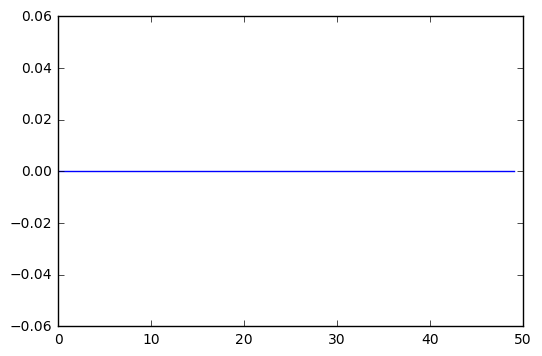

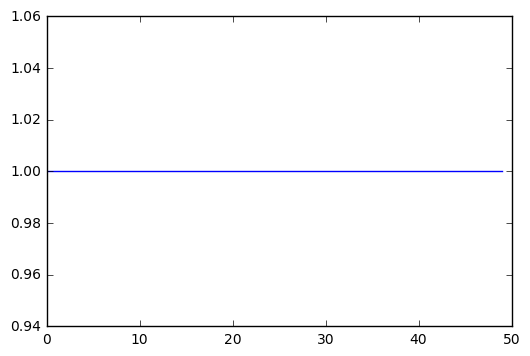

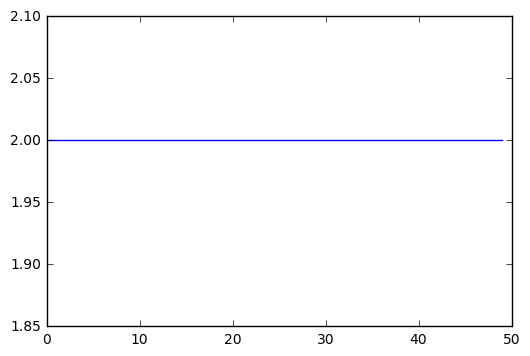

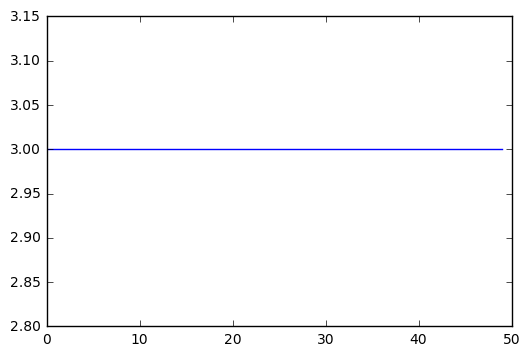

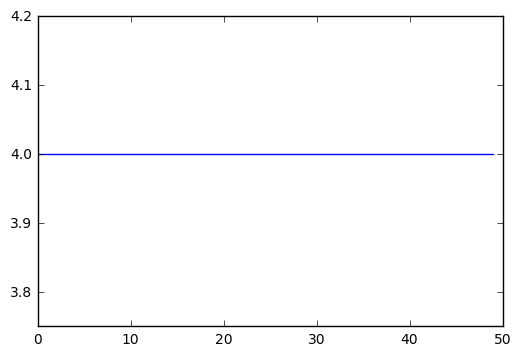

In [21]:
for n in range(5):
    plt.figure()
    plt.plot(TLB_LDA_Post_Samps[0][n,:])

##### Export files with posterior samples and top words:

In [ ]:
# Save posterior samples and top words to pickle files:
pickle.dump(TLB_LDA_Post_Samps, open("TLB_LDA_Post_Samps.p", "wb"))
pickle.dump(topic_top_words, open("topic_top_words.p", "wb"))

# Load posterior samples pickle file: 
#pickle.load(open("TLB_LDA_Post_Samps.p", "rb"))

##### Unused functions:

In [ ]:
# Create z_given_b_x_phi_theta function:
def z_given_b_x_phi_theta(b, x, phi, theta, num_obs, num_topics, num_blocks):
    z_w_n = np.array([np.zeros(len(n)).astype(np.int64) for n in x])
    for n_ind in range(num_obs):
        log_q_kwn = np.log(phi[:,x[n_ind]]) + np.log(theta[b[n_ind], :])[:,None]
        for w_ind in range(len(x[n_ind])):
            exp_log_p_kwn = np.exp(log_q_kwn[:,w_ind] - logsumexp(log_q_kwn[:,w_ind]))
            z_w_n[n_ind][w_ind] = np.random.multinomial(1,exp_log_p_kwn).argmax()
    return z_w_n

In [ ]:
# Write Cython function to help speed up sampling of z|- from multinomial:

In [ ]:
# %%cython --annotate

# import cython
# import numpy as np
# import itertools
# import time
# cimport numpy as np
# from scipy.special import logsumexp

# @cython.boundscheck(False)
# @cython.wraparound(False)
# @cython.cdivision(True)
# def topic_assign(long[:] b, long[:] all_docs_words_vec, long[:] cum_doc_lengths, double[:,:] phi, double[:,:] theta, long num_obs, long num_topics, long num_blocks): 
#     cdef long n_ind, w_index, w_indicator
#     cdef long start_word_ind = 0
#     cdef long end_word_ind = 0
#     cdef long[:] z_vec = np.zeros(cum_doc_lengths[len(cum_doc_lengths)-1], dtype=np.int64)
#     cdef double[:] log_q_kwn_w = np.zeros(num_topics)
#     cdef double[:] exp_log_p_kwn_w = np.zeros(num_topics)
#     for n_ind in range(num_obs):
#         if n_ind > 0: 
#             start_word_ind = cum_doc_lengths[n_ind-1]
#         end_word_ind = cum_doc_lengths[n_ind]  
#         for w_index in range(start_word_ind,end_word_ind):
#             w_indicator = all_docs_words_vec[w_index]
#             log_q_kwn_w = np.log(phi[:,w_indicator]) + np.log(theta[b[n_ind], :])
#             exp_log_p_kwn_w = np.exp(log_q_kwn_w - logsumexp(log_q_kwn_w))
#             z_vec[w_index] = np.random.multinomial(1,exp_log_p_kwn_w).argmax().astype(int) #alias_draw(J, q)
#     return z_vec

# def reconstruct_docs(cum_doc_lengths, z, topic_assignments, num_obs):
#         start_word_ind = 0
#         for n_ind in range(num_obs):
#             if n_ind > 0: 
#                 start_word_ind = cum_doc_lengths[n_ind-1]
#             end_word_ind = cum_doc_lengths[n_ind]  
#             z[n_ind] = np.asarray(topic_assignments[start_word_ind:end_word_ind])
#         return z
    
# def z_given_b_x_phi_theta_cython(b, x, z, phi, theta, num_obs, num_topics, num_blocks):
#     cum_doc_lengths = np.cumsum(list(map(len,x)), dtype=np.int64)
#     all_docs_words_vec = np.array(list(itertools.chain(*x)), dtype=np.int64)
#     topic_assignments = topic_assign(b, all_docs_words_vec, 
#                                      cum_doc_lengths, phi,
#                                      theta, num_obs, num_topics, num_blocks)
#     z = reconstruct_docs(cum_doc_lengths, z, topic_assignments, num_obs)
#     return z

In [ ]:
# %%cython --annotate

# import cython
# import numpy as np
# import time
# cimport numpy as np
# #from scipy.special import logsumexp

# @cython.boundscheck(False)
# @cython.wraparound(False)
# @cython.cdivision(True)
# def sample_mult_prob_matrix_cython(double[:,:] prob_wk_subset, long[:] word_topic_assign):
#     cdef long W = prob_wk_subset.shape[0]
#     #cdef long[:] word_topic_assign = np.zeros(W, dtype=np.int64)
#     cdef long w 
#     for w in range(W):
#         word_topic_assign[w] = np.random.multinomial(1, prob_wk_subset[w,:]).argmax()
#     return word_topic_assign

In [ ]:
# Create sample multinomial function with a generator:
def sample_mult_prob_matrix_gen(prob_wk_subset, word_topic_assign):
    W = prob_wk_subset.shape[0]
    word_topic_assign = (np.random.multinomial(1, prob_wk_subset[w,:]).argmax() for w in range(W))
    return word_topic_assign

In [ ]:
# Create function to sample b given y, z, pi, and theta:
def b_given_y_z_pi_theta_help(y, z, pi, theta, num_blocks):
    theta_bz = theta[:,z].prod(axis=1)
    if len(y) < 0:
        pi_by = np.repeat(1, num_blocks)
    else:
        pi_by = pi[:,[y]].prod(axis=1) 
    p_un_b = 
    p_un_b = p_un_b / np.sum(p_un_b)
    #return np.random.multinomial(1,p_un_b).argmax()
b_given_y_z_pi_theta_help(y_ln[50], z_wn[50], pi_bl, theta_bk)
#pi_bl[:,y_ln[1]].shape
#y_ln[50]

##### Junk code for experimenting:

In [ ]:
# Collect vocabulary of words and set of linked domains:
vocab = dict(zip(set([word for doc in docs_words for word in doc]),np.arange(len(set([word for doc in docs_words for word in doc])))))
linked_domains = dict(zip(set([link for doc in docs_links for link in doc if link != 'nan']),np.arange(len(set([link for doc in docs_links for link in doc if link != 'nan'])))))

# Note number of observations, size of vocabulary, number of linked domains:
num_obs = len(docs_words)
vocab_size = len(vocab)
num_linked_domains = len(linked_domains)

# Change docs_words and docs_links to numeric X and Y and calculate helper quantities for vectorizing:
x_wn = np.array(list(map(lambda mykeys: np.array([vocab[x] for x in mykeys]), docs_words)))
y_ln = np.array(list(map(lambda mykeys: np.array([linked_domains[y] for y in mykeys if y != 'nan']), docs_links)))
all_words = np.array([word for doc in x_wn for word in doc])
word_doc_assigns = np.array([word for doc in [np.repeat(i, len(docs_words[i])) for i in range(len(docs_words))] for word in doc])
word_topic_assigns = np.array([0 for doc in x_wn for word in doc])
cum_doc_lengths = np.cumsum(list(map(len,x_wn)))
total_num_words = len([word for doc in x_wn for word in doc])
total_num_links = len([link for doc in y_ln for link in doc])

# Initialize arrays of all zeros to store posterior samples:
b_ns = np.zeros((num_obs, (num_samps - num_burn))) # matrix of block assignments for each observation in each iteration
z_wn_last = np.array([np.zeros(len(n)) for n in x_wn]) # a list of 1d arrays to indicate the currect topic assignment for each word of each observation
phi_vks = np.zeros((vocab_size, num_topics, (num_samps - num_burn))) # array for probs for each word in each topic on each iteration
pi_bls = np.zeros((num_blocks, num_linked_domains, (num_samps - num_burn))) # array for probs for each link in each block on each iteration
theta_bks = np.zeros((num_blocks, num_topics, (num_samps - num_burn))) # array for probs for each topic in each block on each iteration    

# Randomly simulate initial values from flat priors and flat (augmented) likelihoods:
#b_n = np.random.choice(np.arange(num_blocks), size = num_obs, p = np.repeat(1.0/num_blocks, num_blocks))
b_n = init_block_assigns(num_obs, num_blocks) # Currently blocks are initialized so that each occurs homogenously
z_wn = np.array(list(map(lambda doc: np.random.choice(np.arange(num_topics), size = len(doc), p = np.repeat(1.0/num_topics, num_topics)), x_wn)))
phi_vk = np.transpose(np.random.dirichlet(np.repeat(beta,vocab_size), size = num_topics))
pi_bl = np.random.dirichlet(np.repeat(gamma,num_linked_domains), size = num_blocks)
theta_bk = np.random.dirichlet(np.repeat(alpha,num_topics), size = num_blocks)

#t0 = time.time()
        #z_wn = z_given_b_x_phi_theta(b_n, x_wn, z_wn, phi_vk, theta_bk, num_obs, num_topics, num_blocks)
        #print("time per iteration for double loop through numpy array of numpy arrays:")
        #print(time.time() - t0)
        
#t0 = time.time()
start_samp_z = time.time()
z_wn = z_given_b_x_phi_theta_vec(all_words, word_topic_assigns, word_doc_assigns, cum_doc_lengths, b_n, z_wn, phi_vk, theta_bk, num_obs, num_topics, num_blocks, num_cores)
print("samp z time:")
print(time.time()-start_samp_z)
#print("time per iteration for double loop through numpy array of numpy arrays:")
#print(time.time() - t0)

start_find_counts = time.time()
c_vk, c_bl, c_bk = find_counts(b_n, x_wn, y_ln, z_wn, num_obs, num_topics, num_blocks, num_linked_domains, vocab_size)
print("find counts time:")
print(time.time()-start_find_counts)

start_phi = time.time()
phi_vk = phi_given_c_x_z(c_vk, x_wn, z_wn, phi_vk, beta, vocab_size, num_topics)
print("phi time:")
print(time.time()-start_phi)

start_pi = time.time()
pi_bl = pi_given_b_c_y(b_n, c_bl, y_ln, pi_bl, gamma, num_blocks, num_linked_domains)
print("pi time:")
print(time.time()-start_pi)

start_theta = time.time()
theta_bk = theta_given_b_c_z(b_n, c_bk, z_wn, theta_bk, alpha, num_blocks, num_topics)
print("theta time:")
print(time.time()-start_theta)

#start_b = time.time()
#b_n = b_given_y_z_pi_theta_fast(b_n, y_ln, z_wn, pi_bl, theta_bk, num_obs, num_blocks)
#print("b time:")
#print(time.time()-start_b)

    
start_pool = time.time()
pool = mp.Pool(num_cores)
print("pool time:")
print(time.time()-start_pool)
indices = np.arange(num_obs)
start_partition = time.time()
partition_indices = np.array_split(indices, indices.shape[0]//(indices.shape[0]//num_cores))
print("partition time:")
print(time.time()-start_partition)
#result_arrays = pool.map(sample_mult_prob_matrix_cython, (prob_wk[partition_indices[i], :] for i in range(num_cores)))
start_map_sample = time.time()
result_arrays = pool.starmap(partial(b_given_y_z_pi_theta_help, pi = pi_bl, theta = theta_bk, num_blocks = num_blocks), zip(y_ln, z_wn))
#result_arrays = pool.starmap(b_given_y_z_pi_theta_help(b, y, z, pi, theta, num_obs, num_blocks)
#, (b[partition_indices[i]], y[partition_indices] for i in range(num_cores)))
print("map sample time:")
print(time.time()-start_map_sample)
#result_arrays = list(map(sample_mult_prob_matrix_cython, (prob_wk[partition_indices[i], :] for i in range(num_cores))))
start_concat = time.time()
block_assigns = np.concatenate(result_arrays).ravel()
print("concat time:")
print(time.time()-start_concat)